# Real-NVPs

**Goal:** Implement a Real-NVP model on your own and evaluate the results on some **toy problem**.

![](flow-graphic.png)


**Table of Contents:**
1. [Dataset](#data) 
2. [Model architecture](#model)
- Q1: Implement the t (translation) NN in the `CouplingLayer` 
- Q2: Implement the forward function n the `CouplingLayer` 
- Q3: Implement the log(det(Jacobian)) for the reverse function
3. [Training](#train)
- Q4: Add the loss function definition to the `train` function
- Q5: Visualize the density of $f^{-1}(X)$ for a trained model
4. [Visualizations](#viz)
- Code already provided, just for fun to look at what the step-by-step flow denisty propogation is doing.
5. [Bonus: Conditional generative model](#condFlow)

## 1. Dataset
<a name="data"></a>

Let's use the crescent moons dataset as a nice 2d test bed example

In [1]:
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

import math
import numpy as np
import torch
import torch.nn as nn

In [2]:
nsamples = 30_000
noise = 0.05
X = make_moons(nsamples, noise=noise)[0]

Text(0, 0.5, '$X_1$')

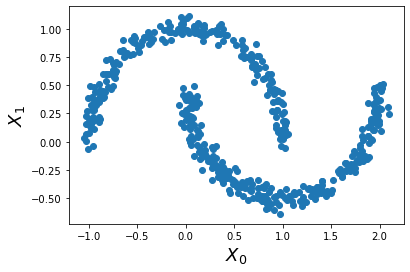

In [3]:
nViz=500

plt.scatter(X[:nViz,0], X[:nViz,1])

plt.xlabel('$X_0$',fontsize=18)
plt.ylabel('$X_1$',fontsize=18)

## 2. Model architecture
<a name="model"></a>

### Implementation detail: Masking

In the lecture, we talked about the affine transformations transforming a bipartite grouping of the variables (via "coupling layers").

I.e, for $f: x \rightarrow y, x,y \in \mathbb{R}^n$, we group the variables into the <span style="color:deeppink">transforming dimensions</span> and <span style="color:blue">conditioning dimensions</span>, and just transfom one set of variables at a time, while leaving the others stationary, e.g,

$$ y_{1:d} = x_{1:d} $$
$$y_{d+1:D} = x_{d+1:D} \cdot s(x_{1:d})  + t(x_{1:d})$$

(and in the next step of the flow $x_{1:d}$ would get transformed while $x_{d+1:D}$ would be useds for the conditioning).

As described in [1605.08803](https://arxiv.org/abs/1605.08803), it's common to implement the variable partitioning with a binary mask, here denoted $m$, where
$$
m_i = 
\begin{cases}
0, \quad \text{transforming dimension} \\
1, \quad \text{conditioning dimension}
\end{cases}
$$
This allows us to implement the the update eqs for a single flow step more succinctly as:

$$y =  m \odot x + (1-m) \odot \left[x \cdot s(m \odot x )  + t(m \odot x ) \right].$$



We simplify a little bit to try to get into a more succinct form.

- Write in terms of `log_s` (as this is the NN we have).

$$y =  m \odot x + (1-m) \odot \left[x \cdot \exp \log s(m \odot x )  + t(m \odot x ) \right]$$

- Group the terms with $x$ together.

$$y =  x \odot \left[ m  + (1-m) \cdot \exp \log s(m \odot x ) \right]  + t(m \odot x ) \cdot (1-m)$$

We want to take the `exp` outside of the expression in $[ \ldots ]$.

Note that

$$\exp(m_i) = 
1, \  \ \text{if} \ m_i = 0 .$$


$$y =  x \odot  \exp \left[( \log s(m \odot x ) \cdot (1-m)  \right]  + t(m \odot x ) \cdot (1-m)$$

In [4]:
class CouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, num_hidden, mask):
        super(CouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.mask = mask
            
        self.log_s_net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_inputs))
        
        '''
        TO DO (Q1): Setup the network for the shift of the affine transformation
        - Use 2 hidden layers
        - `num_hidden` units / hidden layer
        - ReLU activation
        '''
        # self.t_net = 
        
        
        # Solution :
        self.t_net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_inputs))

    def forward(self, inputs,  mode='forward'):
        '''
        Returns a tuple with 
        - the transofrmation, f(inpts)
        - and the log Jacobian of f

        Whether we apply f or f^{-1} depends on whether we're running 
        with `mode` as forward or reverse
        '''
        mask = self.mask
        masked_inputs = inputs * mask
        
        if mode == 'forward':
            
            '''
            TO DO (Q2): Implement the transformation
            '''
            
            # log_s = 
            # s = 
            # t = 
            # out = 
            
            log_s = self.log_s_net(masked_inputs) * (1 - mask)
            t = self.t_net(masked_inputs) * (1 - mask)
            s = torch.exp(log_s)
            
            out = inputs * s + t
            
            return out, log_s.sum(-1, keepdim=True)
                        
        else:
            
            log_s = self.log_s_net(masked_inputs) * (1 - mask)
            t = self.t_net(masked_inputs) * (1 - mask)
            s = torch.exp(log_s)
            
            '''
            TO DO (Q3): Implement the Jacobian
            '''
            # log_jacob = 
            
            # Soln
            log_jacob = -log_s.sum(-1, keepdim=True)
            
            return (inputs - t) / s, log_jacob

### Sanity check

After working through steps (1) -- (3), the CouplingLayer class should work :) 

And the code block below let's you check the implementation.

![](frogs.png)

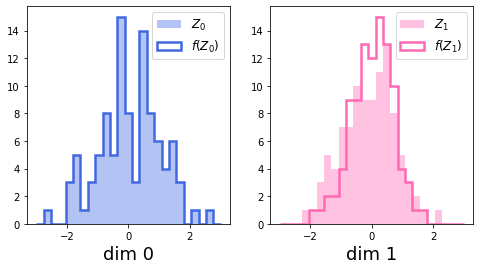

In [5]:
# Generate a random normally distributed vector 
# with 100 samples in 2 dimensions
Z = torch.randn(100,2)

# dim 0 will be the conditioning variable
# dim 1 will be the transforming variable
mask = torch.Tensor([1,0])
f = CouplingLayer(2,64,mask)

with torch.no_grad():
    out, log_p = f(Z)

# The histogram shows the inputs and the outputs
fig, axes = plt.subplots(1,2,figsize=(8,4))

for i, ax, c in zip([0,1],axes,['royalblue','hotpink']):

    ax.hist(Z[:,i].numpy(),25,(-3,3),label=f'$Z_{i}$',color=c,alpha=.4)
    ax.hist(out[:,i].numpy(),25,(-3,3),label=f'$f(Z_{i})$',color=c,lw=2.5,histtype='step')
    
    ax.set_xlabel(f'dim {i}',fontsize=18)
    ax.legend(fontsize=12)
    
plt.show()

^ Is the result what you expected?

The `FlowSequential` then stitches together a sequence of CouplingLayers together to form a single model that can evaluate eitheer

For this tutorial we're giving a ready-to-go implementation `FlowSequential` class :)


In [6]:
class FlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, mode='forward'):
        """ Performs a forward or reverse pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        
        self.num_inputs = inputs.size(-1)
        
        # Initialize logdets to 0
        logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['forward', 'reverse']
        if mode == 'forward':
            for module in self._modules.values():
                inputs, logdet = module(inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs):
        u, log_jacob = self(inputs,mode='reverse')
          
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(-1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, num_samples=None):
        
        noise = torch.Tensor(num_samples, self.num_inputs).normal_()    
        noise = noise.to(device)

        samples = self.forward(noise, mode='forward')[0]
        
        return samples

### Flow architecture

Let's consider a flow with 9 blocks and the $\log(s)$ and $t$ NNs with 64 hidden units per hidden layer.

In [7]:
num_blocks=9
num_hidden=64

In [8]:
# Check for a GPU
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device='cpu'
    
print(device)

cuda:0


In [9]:
num_inputs = X.shape[1]

mask = torch.arange(0, num_inputs) % 2
mask = mask.to(device).float()

modules=[]

for _ in range(num_blocks):
    modules.append( CouplingLayer( num_inputs, num_hidden, mask) )
    mask = 1 - mask

In [10]:
model = FlowSequential(*modules)

## 4. Training
<a name="train"></a>

In [11]:
X_torch = torch.Tensor(X.astype(np.float32))

In [12]:
batch_size=256

nTrain=24_000
nVal=3_000

Text(0, 0.5, '$Z_1$')

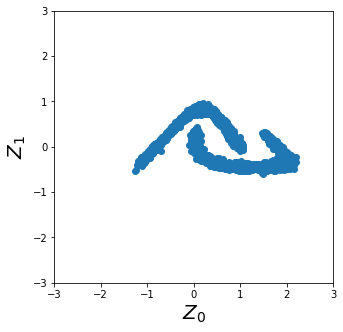

In [13]:
# For comparison with a later cell block ... look at the density 
# of the _test data_ before training the odel

model = model.to(device)
with torch.no_grad():
    Z_test = model(X_torch[nTrain+nVal:].to(device),mode='reverse')[0].cpu().numpy()

plt.figure(figsize=(5,5))

plt.scatter(*Z_test.T)

plt.xlim(-3,3)
plt.ylim(-3,3)

plt.xlabel('$Z_0$',fontsize=20)
plt.ylabel('$Z_1$',fontsize=20)


In [14]:
kwargs = {'num_workers': 4, 'pin_memory': True}  if torch.cuda.is_available() else {}

In [15]:
train_loader = torch.utils.data.DataLoader(
    X_torch[:nTrain], batch_size=batch_size, shuffle=True,**kwargs)

valid_loader = torch.utils.data.DataLoader(
    X_torch[nTrain : nTrain+nVal],
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    X_torch[nTrain+nVal :],
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

In [16]:
def train(model, train_loader, opt):
    
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):

        data = data.to(device)    
        opt.zero_grad()
        
        '''
        TO DO (Q4): Fill in the expression for the loss
        '''
        # loss = 
        loss = -model.log_probs(data).mean()
        train_loss += loss.item()
        
        loss.backward()
        opt.step()
        
    train_loss /= len(train_loader)
    return train_loss

In [17]:
def validate(model, loader, prefix='Validation'):
    
    model.eval()
    val_loss = 0

    for batch_idx, data in enumerate(loader):

        data = data.to(device)
            
        with torch.no_grad():
            val_loss += -model.log_probs(data).sum().item()  # sum up batch loss
     
    val_loss /= len(loader.dataset)
    return val_loss 

In [18]:
lr=1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [19]:
def draw_model(model, cond_input=None, title=''):
    '''
    Goal: Given the given model weights, show
    (1) The density
    (2) Samples from p_X(x)
    
    Inputs:
    - model that we're plotting the density of
    - cond_input: Extra logic for the conditional gen model
                  (bonus prob)
    - title: Super title over 2 subfigs
    '''
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),
                                  gridspec_kw={'hspace':10})

    # Title the plot with the log(p) on the validation set
    if title:
        fig.suptitle(title)

    '''
    (1) Plot the density
    '''
    x = np.linspace(-1,2)
    y = np.linspace(-.75,1.25)

    xx,yy = np.meshgrid(x,y)

    X_grid = np.vstack([xx.flatten(),yy.flatten()]).T.astype(np.float32)
    X_grid.T

    X_grid = torch.tensor(X_grid).to(device)

    if cond_input:
        # For last (bonus) prob
        y0,y1 = cond_input
        Y_grid = torch.ones_like(X_grid).to(device)
        Y_grid[:,0] = y0
        Y_grid[:,1] = y1
    
        with torch.no_grad():
            log_probs = model.log_probs(X_grid,Y_grid).cpu().numpy()

    else:
        with torch.no_grad():
            log_probs = model.log_probs(X_grid).cpu().numpy()

    ax1.pcolormesh(xx,yy,np.exp(log_probs.reshape(50,50)),shading='auto',cmap='coolwarm')

    ax1.set_xlabel('$X_0$',fontsize=12)
    ax1.set_ylabel('$X_1$',fontsize=12)

    '''
    (2) Plot samples from the model
    '''
    with torch.no_grad():
        
        if cond_input:
            # For last (bonus) prob
            Y_con = torch.ones(500,2).to(device)
            Y_con[:,0] = y0
            Y_con[:,1] = y1
            X_gen = model.sample(Y_con).cpu().numpy()
        else:
            X_gen = model.sample(500).cpu().numpy()
        
    ax2.scatter(*X_gen.T)

    ax2.set_xlabel('$X_0$',fontsize=12)
    ax2.set_ylabel('$X_1$',fontsize=12)

    ax2.set_xlim(x[[0,-1]])
    ax2.set_ylim(y[[0,-1]])

    plt.show()


Epoch 0: train loss = 1.9707, val loss = 1.8266


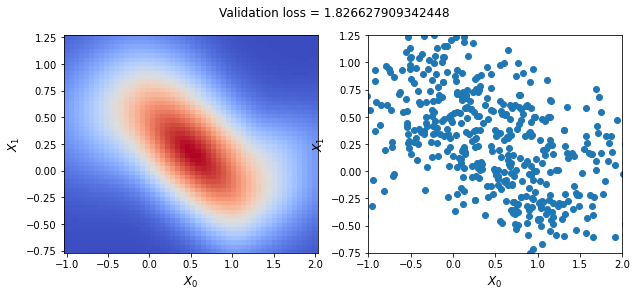

Epoch 1: train loss = 1.7515, val loss = 1.6917
Epoch 2: train loss = 1.5795, val loss = 1.4519
Epoch 3: train loss = 1.2526, val loss = 1.0900
Epoch 4: train loss = 0.9855, val loss = 0.8795
Epoch 5: train loss = 0.8482, val loss = 0.7792
Epoch 6: train loss = 0.7476, val loss = 0.6675
Epoch 7: train loss = 0.6303, val loss = 0.5602
Epoch 8: train loss = 0.5301, val loss = 0.4781
Epoch 9: train loss = 0.4678, val loss = 0.4315
Epoch 10: train loss = 0.4433, val loss = 0.4415


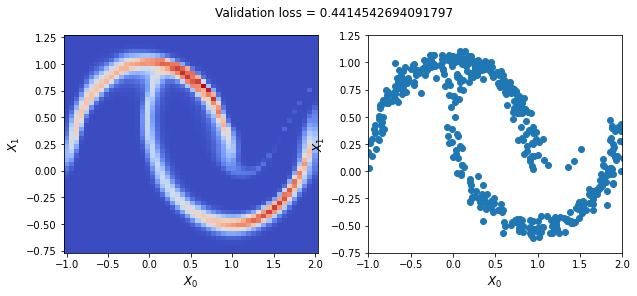

Epoch 11: train loss = 0.4225, val loss = 0.4036
Epoch 12: train loss = 0.4131, val loss = 0.3952
Epoch 13: train loss = 0.4027, val loss = 0.4021
Epoch 14: train loss = 0.4068, val loss = 0.3942
Epoch 15: train loss = 0.3947, val loss = 0.3806
Epoch 16: train loss = 0.3957, val loss = 0.3874
Epoch 17: train loss = 0.3837, val loss = 0.3895
Epoch 18: train loss = 0.3886, val loss = 0.3664
Epoch 19: train loss = 0.3819, val loss = 0.3709
Epoch 20: train loss = 0.3786, val loss = 0.3633


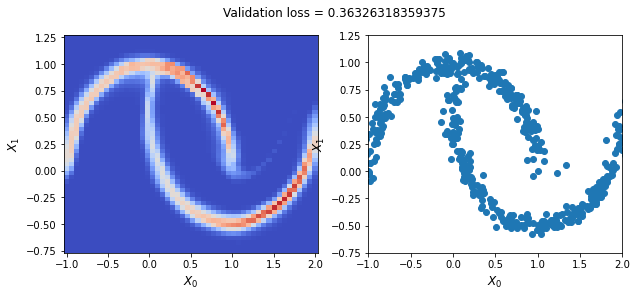

Epoch 21: train loss = 0.3793, val loss = 0.3689
Epoch 22: train loss = 0.3740, val loss = 0.3564
Epoch 23: train loss = 0.3734, val loss = 0.3620
Epoch 24: train loss = 0.3704, val loss = 0.3749
Epoch 25: train loss = 0.3786, val loss = 0.3753
Epoch 26: train loss = 0.3713, val loss = 0.3842
Epoch 27: train loss = 0.3646, val loss = 0.3485
Epoch 28: train loss = 0.3663, val loss = 0.3486
Epoch 29: train loss = 0.3614, val loss = 0.3522
Epoch 30: train loss = 0.3573, val loss = 0.3556


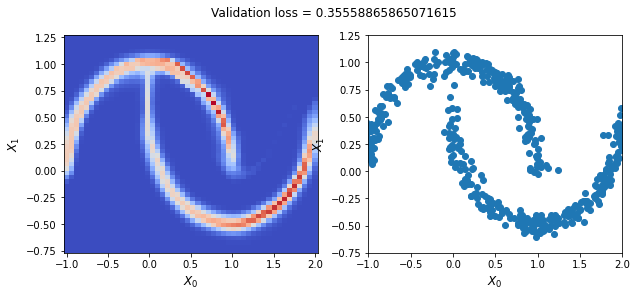

Epoch 31: train loss = 0.3600, val loss = 0.3516
Epoch 32: train loss = 0.3603, val loss = 0.3527
Epoch 33: train loss = 0.3631, val loss = 0.3428
Epoch 34: train loss = 0.3604, val loss = 0.3644
Epoch 35: train loss = 0.3585, val loss = 0.3426
Epoch 36: train loss = 0.3571, val loss = 0.3603
Epoch 37: train loss = 0.3591, val loss = 0.3381
Epoch 38: train loss = 0.3527, val loss = 0.3411
Epoch 39: train loss = 0.3522, val loss = 0.3440
Epoch 40: train loss = 0.3591, val loss = 0.3373


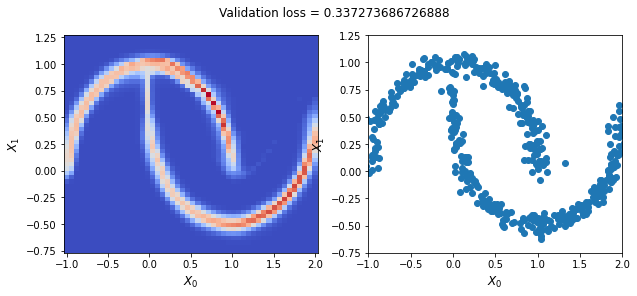

Epoch 41: train loss = 0.3522, val loss = 0.3382
Epoch 42: train loss = 0.3474, val loss = 0.3396
Epoch 43: train loss = 0.3484, val loss = 0.3497
Epoch 44: train loss = 0.3519, val loss = 0.3330
Epoch 45: train loss = 0.3529, val loss = 0.3441
Epoch 46: train loss = 0.3528, val loss = 0.3324
Epoch 47: train loss = 0.3502, val loss = 0.3416
Epoch 48: train loss = 0.3489, val loss = 0.3374
Epoch 49: train loss = 0.3483, val loss = 0.3432
Epoch 50: train loss = 0.3485, val loss = 0.3420


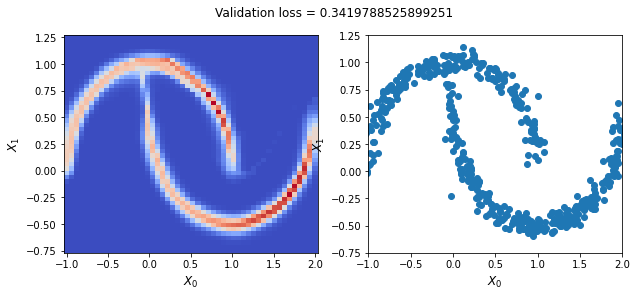

In [20]:
epochs=51

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for i in range(epochs):
    
    train_losses[i] = train(model, train_loader, optimizer)
    val_losses[i] = validate(model, valid_loader)

    print(f'Epoch {i}: train loss = {train_losses[i]:.4f}, val loss = {val_losses[i]:.4f}')
        
    if i % 10 == 0:
        # Draw the model prediction
        draw_model(model,title=f'Validation loss = {val_losses[i]}')
        


Plot the training and validation loss.

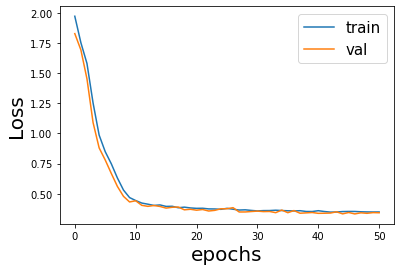

In [21]:
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')

plt.xlabel('epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=15)
plt.show()

**What's the density of the test data _after_ training?**

Text(0, 0.5, '$Z_1$')

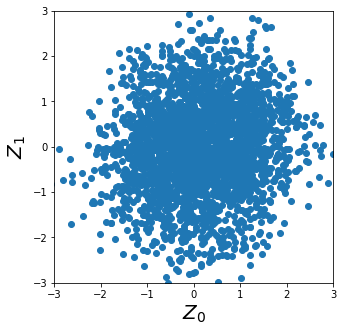

In [22]:
'''
TO DO (Q5): Get the (2d) density of the test data
'''

with torch.no_grad():
    Z_test = model(X_torch[nTrain+nVal:].to(device),mode='reverse')[0].cpu().numpy()

plt.figure(figsize=(5,5))

plt.scatter(*Z_test.T)

plt.xlim(-3,3)
plt.ylim(-3,3)

plt.xlabel('$Z_0$',fontsize=20)
plt.ylabel('$Z_1$',fontsize=20)


Is this what we expect for the trained flow?

## 4. Vizualize the flow
<a name="viz"></a>

This was a 9 step flow, so let's sample some noise, and look at each of the 10 steps of the flow that goes into the crescent moon density :)

In [23]:
N = 500
Z = torch.randn(N,2)

In [24]:
cmask = np.where((Z[:,0]<0) & (Z[:,1] >0),0,
                np.where((Z[:,0]>0) & (Z[:,1] >0),1,
                        np.where((Z[:,0]>0) & (Z[:,1]<0),2,3)))

In [25]:
colors = [f'C{i}' for i in cmask ]

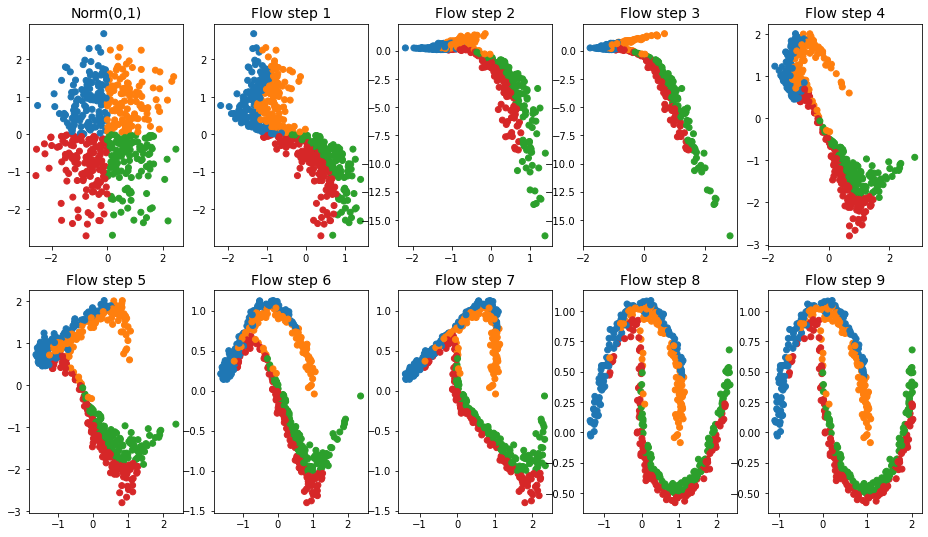

In [26]:
nrows = 2
ncols = 5

fig, ax = plt.subplots(nrows,ncols,figsize=(16,9))

ax[0,0].scatter(*Z.T, color=colors)
ax[0,0].set_title('Norm(0,1)',fontsize=14)

'''
Let each subsequent step of the flow viz the jazz
'''

Z_gpu = Z.float().to(device)

for k,module in enumerate(modules):
    
    with torch.no_grad():    
        Z_gpu, _ = module(Z_gpu)
    
    
    i = (k+1) // ncols
    j = (k+1) % ncols
    
    ax[i,j].set_title(f'Flow step {k+1}',fontsize=14)
    
    ax[i,j].scatter(*Z_gpu.cpu().numpy().T, color=colors)
      
plt.show()

# 5. Bonus: Conditional flow

Lots of applications in science involve conditional flow models, can you extend our the model we built here to be conditioned on the center point for the moon? 

**Plan:** 
- Train sampling moon density centers $y \in \mathbb{R}^2$ **uniformly** from [0,1]

Recall, we were training the 30k training samples for modelling 2 dimensions.

In [27]:
nsamples,num_inputs

(30000, 2)

In [28]:
Y = torch.Tensor(nsamples, num_inputs).uniform_()

In [29]:
X_cond = X_torch + Y

**Let's look at the prediction for some slices of the conditional output**
- $0 < y_0 < .05$ and $0 < y_1 < .05$
- $0.5 < y_0 < .55$ and $.5 < y_1 < .55$
- $0.5 < y_0 < .55$ and $.5 < y_1 < .55$

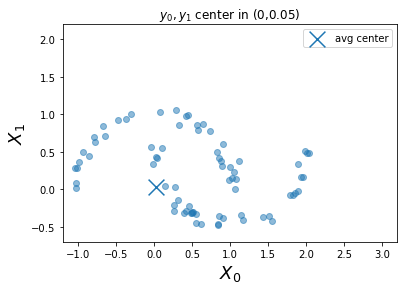

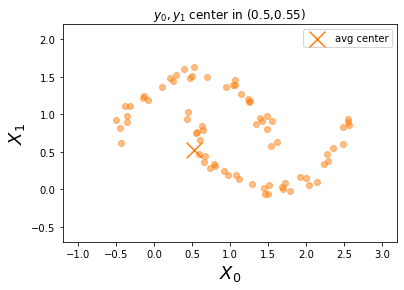

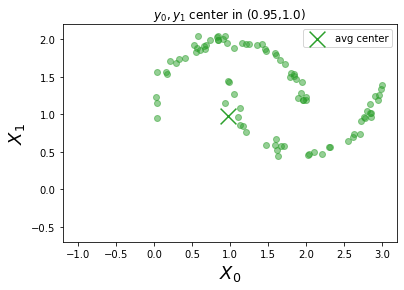

In [30]:
dy = .05
for i,y_min in enumerate([0,.5,1-dy]):
    
    y_max = y_min+dy
    mi = (Y[:,0] > y_min) & (Y[:,0] < y_max)
    mi = mi & (Y[:,1] > y_min) & (Y[:,1] < y_max)
    
    y_avg = .5 * (y_min + y_max)
    
    c=f'C{i}'
    plt.scatter(*X_cond[mi].T.numpy(),alpha=.5,color=c)
    plt.scatter([y_avg],[y_avg],250,marker='x',label='avg center',color=c)
    plt.xlabel('$X_0$',fontsize=18)
    plt.ylabel('$X_1$',fontsize=18)
    plt.legend()
    plt.title(f'$y_0,y_1$ center in ({y_min},{y_max})')
    
    plt.xlim(-1.2,3.2)
    plt.ylim(-.7,2.2)
    plt.show()
    

### TO DO: Implement the conditional flow model

**Hint 1:** Extend the coupling layer to a conditional coupling layer

In [31]:
class CondCouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, num_cond_inputs, num_hidden, mask):
        super(CondCouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.num_cond_inputs = num_cond_inputs
        self.mask = mask
        
        num_all_inputs = num_inputs + num_cond_inputs
            
        self.log_s_net = nn.Sequential(
            nn.Linear(num_all_inputs, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_inputs))
        
        self.t_net = nn.Sequential(
            nn.Linear(num_all_inputs, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_inputs))

    def forward(self, inputs, cond_inputs,  mode='forward'):
        '''
        Returns a tuple with 
        - the transofrmation, f(inpts)
        - and the log Jacobian of f

        Whether we apply f or f^{-1} depends on whether we're running 
        with `mode` as forward or reverse
        '''
        mask = self.mask
        masked_inputs = inputs * mask
        
        all_inputs = torch.cat([masked_inputs, cond_inputs],axis=1)
        
        if mode == 'forward':
            
            log_s = self.log_s_net(all_inputs) * (1 - mask)
            t = self.t_net(all_inputs) * (1 - mask)
            s = torch.exp(log_s)
            
            out = inputs * s + t
            
            return out, log_s.sum(-1, keepdim=True)
                        
        else:
            
            log_s = self.log_s_net(all_inputs) * (1 - mask)
            t = self.t_net(all_inputs) * (1 - mask)
            s = torch.exp(log_s)

            log_jacob = -log_s.sum(-1, keepdim=True)
            
            return (inputs - t) / s, log_jacob

**Hint 2:** Implement a `CondFlowSequential` class that calls the `CondCouplingLayer` class.

In [32]:
class CondFlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, cond_inputs, mode='forward'):
        """ Performs a forward or reverse pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        
        self.num_inputs = inputs.size(-1)

        logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['forward', 'reverse']
        if mode == 'forward':
            for module in self._modules.values():
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, cond_inputs):
        u, log_jacob = self(inputs, cond_inputs,mode='reverse')
          
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(-1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, cond_inputs, num_samples=None):
        
        if num_samples is None:
            num_samples = cond_inputs.shape[0]
        
        assert cond_inputs.shape[0] == num_samples
        
        noise = torch.Tensor(num_samples, self.num_inputs).normal_()
        noise = noise.to(device)

        samples = self.forward(noise, cond_inputs, mode='forward')[0]
        
        return samples

**Put the pieces together to define a flow**

In [33]:
mask

tensor([1., 0.], device='cuda:0')

In [45]:
# Extending the code that we had before
num_cond_inputs = Y.shape[1]

modules=[]

for _ in range(num_blocks):
    modules.append( CondCouplingLayer( num_inputs, num_cond_inputs, num_hidden, mask) )
    mask = 1 - mask

In [46]:
# To DO: Define the conditional flow from these modules
cond_flow = CondFlowSequential(*modules)

In [47]:
cond_flow = cond_flow.to(device)

**Training code**

It's the same as before, just evaluating the conditional generative model, so we'll just give you the training functions.

We'll just use a `from torch.utils.data.Dataset` first to pass to the `DataLoaders` that we'll create :)

In [48]:
from torch.utils.data import Dataset

class CondMoonsDataset(Dataset):
    '''
    Skeleton class taken from:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    '''
    def __init__(self,nExamples,noise=0.05):
        
        X_np = make_moons(nExamples, noise=noise)[0]
        X = torch.Tensor(X_np).float()
            
        num_inputs = X.shape[1]
        Y = torch.Tensor(nExamples, num_inputs).uniform_()
         
        X = X+Y
            
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [49]:
cond_train_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nTrain), 
    batch_size=batch_size, shuffle=True,**kwargs)

cond_valid_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nVal),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nVal),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

In [50]:
def cond_train(model, train_loader, opt):
    
    model.train()
    train_loss = 0

    for batch_idx, (X,Y) in enumerate(train_loader):
        
        X = X.to(device) 
        Y = Y.to(device) 
        opt.zero_grad()
        
        loss = -model.log_probs(X,Y).mean()
        train_loss += loss.item()
        
        loss.backward()
        opt.step()
        
    train_loss /= len(train_loader)
    return train_loss

def cond_validate(model, loader, prefix='Validation'):
    
    model.eval()
    val_loss = 0

    for batch_idx, (X,Y) in enumerate(loader):

        X = X.to(device) 
        Y = Y.to(device) 
            
        with torch.no_grad():
            val_loss += -model.log_probs(X,Y).sum().item()  # sum up batch loss
     
    val_loss /= len(loader.dataset)
    return val_loss 

Epoch 0: train loss = 2.3849, val loss = 1.9432


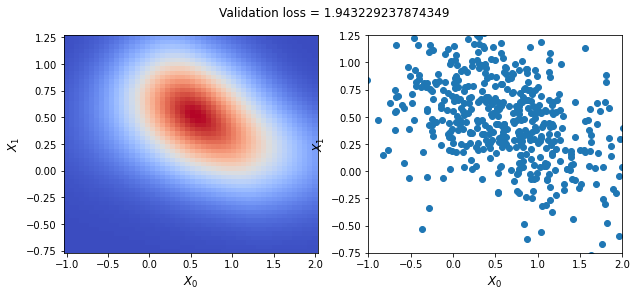

Epoch 1: train loss = 1.8858, val loss = 1.8245
Epoch 2: train loss = 1.7781, val loss = 1.7199
Epoch 3: train loss = 1.6605, val loss = 1.5927
Epoch 4: train loss = 1.5305, val loss = 1.4588
Epoch 5: train loss = 1.3163, val loss = 1.1905
Epoch 6: train loss = 1.1003, val loss = 1.0362
Epoch 7: train loss = 0.9586, val loss = 0.8958
Epoch 8: train loss = 0.8794, val loss = 0.8200
Epoch 9: train loss = 0.8254, val loss = 0.7956
Epoch 10: train loss = 0.7747, val loss = 0.7591


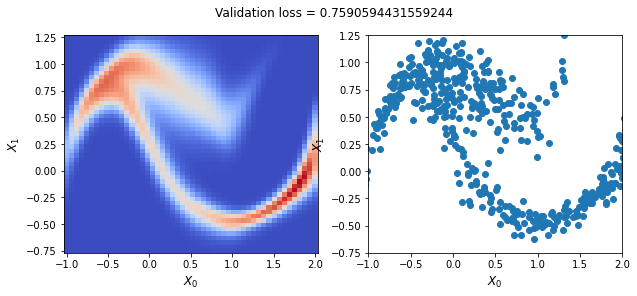

Epoch 11: train loss = 0.7362, val loss = 0.7102
Epoch 12: train loss = 0.6948, val loss = 0.6686
Epoch 13: train loss = 0.6697, val loss = 0.6991
Epoch 14: train loss = 0.6455, val loss = 0.6104
Epoch 15: train loss = 0.6120, val loss = 0.6087
Epoch 16: train loss = 0.5902, val loss = 0.6727
Epoch 17: train loss = 0.5816, val loss = 0.5722
Epoch 18: train loss = 0.5670, val loss = 0.5490
Epoch 19: train loss = 0.5581, val loss = 0.5740
Epoch 20: train loss = 0.5581, val loss = 0.5433


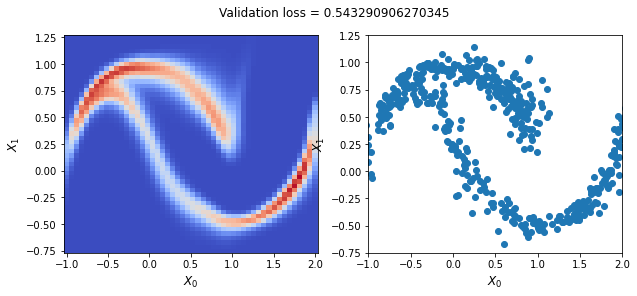

Epoch 21: train loss = 0.5448, val loss = 0.5502
Epoch 22: train loss = 0.5402, val loss = 0.5407
Epoch 23: train loss = 0.5268, val loss = 0.5143
Epoch 24: train loss = 0.5332, val loss = 0.5098
Epoch 25: train loss = 0.5174, val loss = 0.4910
Epoch 26: train loss = 0.5123, val loss = 0.4919
Epoch 27: train loss = 0.5079, val loss = 0.4967
Epoch 28: train loss = 0.4936, val loss = 0.5114
Epoch 29: train loss = 0.5026, val loss = 0.5157
Epoch 30: train loss = 0.5014, val loss = 0.4811


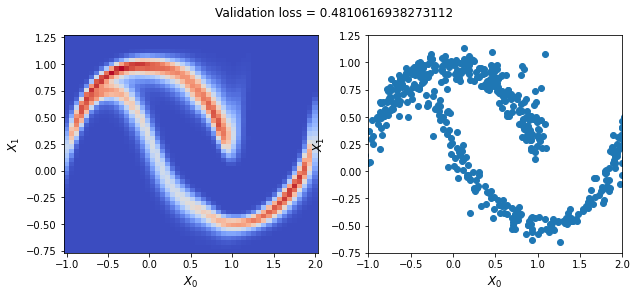

Epoch 31: train loss = 0.4913, val loss = 0.4782
Epoch 32: train loss = 0.4849, val loss = 0.4726
Epoch 33: train loss = 0.4792, val loss = 0.5242
Epoch 34: train loss = 0.4817, val loss = 0.4751
Epoch 35: train loss = 0.4869, val loss = 0.4832
Epoch 36: train loss = 0.4745, val loss = 0.4589
Epoch 37: train loss = 0.4643, val loss = 0.4579
Epoch 38: train loss = 0.4683, val loss = 0.4543
Epoch 39: train loss = 0.4587, val loss = 0.4488
Epoch 40: train loss = 0.4554, val loss = 0.4429


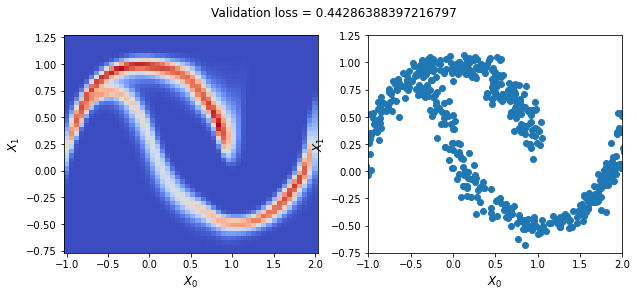

Epoch 41: train loss = 0.4614, val loss = 0.4541
Epoch 42: train loss = 0.4559, val loss = 0.4700
Epoch 43: train loss = 0.4507, val loss = 0.4473
Epoch 44: train loss = 0.4512, val loss = 0.4561
Epoch 45: train loss = 0.4483, val loss = 0.4832
Epoch 46: train loss = 0.4457, val loss = 0.4425
Epoch 47: train loss = 0.4429, val loss = 0.4476
Epoch 48: train loss = 0.4401, val loss = 0.4327
Epoch 49: train loss = 0.4353, val loss = 0.4268
Epoch 50: train loss = 0.4451, val loss = 0.4772


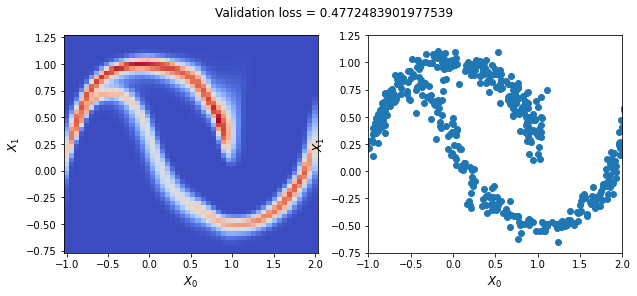

Epoch 51: train loss = 0.4485, val loss = 0.4500
Epoch 52: train loss = 0.4351, val loss = 0.4759
Epoch 53: train loss = 0.4334, val loss = 0.4236
Epoch 54: train loss = 0.4250, val loss = 0.4535
Epoch 55: train loss = 0.4193, val loss = 0.4287
Epoch 56: train loss = 0.4203, val loss = 0.4459
Epoch 57: train loss = 0.4281, val loss = 0.4429
Epoch 58: train loss = 0.4207, val loss = 0.4354
Epoch 59: train loss = 0.4250, val loss = 0.4132
Epoch 60: train loss = 0.4271, val loss = 0.4331


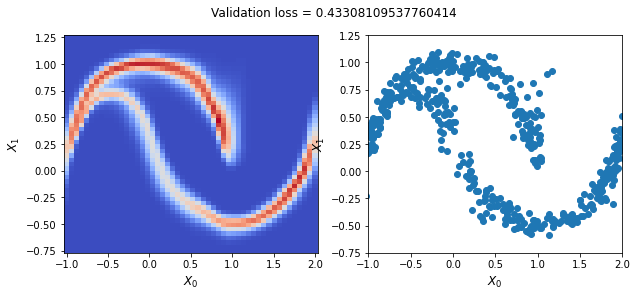

Epoch 61: train loss = 0.4171, val loss = 0.4600
Epoch 62: train loss = 0.4178, val loss = 0.4272
Epoch 63: train loss = 0.4124, val loss = 0.4145
Epoch 64: train loss = 0.4185, val loss = 0.4284
Epoch 65: train loss = 0.4106, val loss = 0.4152
Epoch 66: train loss = 0.4109, val loss = 0.4047
Epoch 67: train loss = 0.4078, val loss = 0.4325
Epoch 68: train loss = 0.4136, val loss = 0.4304
Epoch 69: train loss = 0.4091, val loss = 0.4471
Epoch 70: train loss = 0.4029, val loss = 0.4317


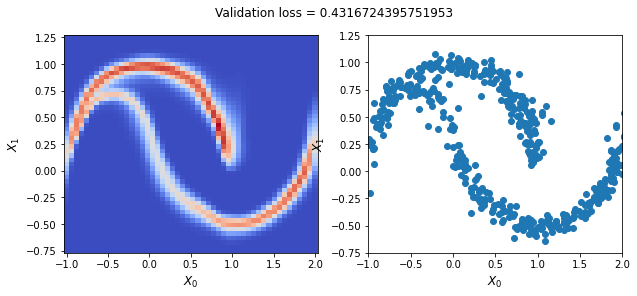

Epoch 71: train loss = 0.4045, val loss = 0.4137
Epoch 72: train loss = 0.4065, val loss = 0.4429
Epoch 73: train loss = 0.4031, val loss = 0.4151
Epoch 74: train loss = 0.4060, val loss = 0.4047
Epoch 75: train loss = 0.4023, val loss = 0.4358
Epoch 76: train loss = 0.3914, val loss = 0.4093
Epoch 77: train loss = 0.3914, val loss = 0.4051
Epoch 78: train loss = 0.4066, val loss = 0.4653


In [ ]:
opt = torch.optim.Adam(cond_flow.parameters(), lr=lr, weight_decay=1e-6)

epochs=81

cond_train_losses = np.zeros(epochs)
cond_val_losses = np.zeros(epochs)

for i in range(epochs):
    
    cond_train_losses[i] = cond_train(cond_flow, cond_train_loader, opt)
    cond_val_losses[i] = cond_validate(cond_flow, cond_valid_loader)

    print(f'Epoch {i}: train loss = {cond_train_losses[i]:.4f}, val loss = {cond_val_losses[i]:.4f}')
        
    if i % 10 == 0:
        # Draw the model prediction
        draw_model(cond_flow,cond_input=[0,0],
                   title=f'Validation loss = {cond_val_losses[i]}')
        

In [ ]:
plt.plot(train_losses,label='train',alpha=.5)
plt.plot(val_losses,label='val',alpha=.5)

plt.plot(cond_train_losses,label='train')
plt.plot(cond_val_losses,label='val')

plt.xlabel('epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=15)
plt.show()

**Sanity check:** What have we learned about crescent moons in the three cases that we had above?

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,3),
                            gridspec_kw={'wspace':.3})

fig.suptitle('Conditional flow')

# Define the density grid
x = np.linspace(-1.2,3.2)
y = np.linspace(-.7,2.2)

xx,yy = np.meshgrid(x,y)

X_grid = np.vstack([xx.flatten(),yy.flatten()]).T.astype(np.float32)
X_grid.T

X_grid = torch.tensor(X_grid).to(device)

'''
Loop over the centers
'''
for yi,ax,cmap in zip([0, 0.5, 1],axs,['Blues','Oranges','Greens']):
    
    # Plot the density
    
    Y_grid = torch.ones_like(X_grid).to(device)
    Y_grid[:,0] *= yi
    Y_grid[:,1] *= yi
    
    with torch.no_grad():
        log_probs = cond_flow.log_probs(X_grid,Y_grid).cpu().numpy()

    ax.pcolormesh(xx,yy,np.exp(log_probs.reshape(50,50)),shading='auto',cmap=cmap)

    ax.set_xlabel('$X_0$',fontsize=12)
    ax.set_ylabel('$X_1$',fontsize=12)

    ax.scatter([yi],[yi],300,marker='x',color='k')
    # break
plt.show()


**Resources:**
- This tutorial for the code in this repo came from the [pytorch-flows](https://github.com/ikostrikov/pytorch-flows) repo.
- The [nflows](https://github.com/bayesiains/nflows.git) is also a very nice package that includes the Real-NVP model and also the RQ-NSF that we also talked about in the lecture.